ArcFace paper: https://arxiv.org/pdf/1801.07698.pdf

**Motivation :Good idea to craete toy Examples for Understandings Complex Concepts**

### Arcface Loss

Intra class compactness and Inter class discrepancy

In [1]:
from fastai.core import *
from fastai.vision import *
from fastai.datasets import *

In [2]:
!pwd

/home/ubuntu/whale


In [3]:
path = untar_data(URLs.MNIST, dest="./data/mnist")

In [4]:
path

PosixPath('data/mnist')

In [5]:
path = Path('../data/mnist/')

In [6]:
path.ls()

[PosixPath('../data/mnist/training'),
 PosixPath('../data/mnist/testing'),
 PosixPath('../data/mnist/models')]

In [7]:
print(len((path/'training').ls()));(path/'training').ls()

7


[PosixPath('../data/mnist/training/6'),
 PosixPath('../data/mnist/training/4'),
 PosixPath('../data/mnist/training/2'),
 PosixPath('../data/mnist/training/1'),
 PosixPath('../data/mnist/training/3'),
 PosixPath('../data/mnist/training/5'),
 PosixPath('../data/mnist/training/0')]

In [8]:
print(len((path/'testing').ls()));(path/'testing').ls()

7


[PosixPath('../data/mnist/testing/6'),
 PosixPath('../data/mnist/testing/4'),
 PosixPath('../data/mnist/testing/2'),
 PosixPath('../data/mnist/testing/1'),
 PosixPath('../data/mnist/testing/3'),
 PosixPath('../data/mnist/testing/5'),
 PosixPath('../data/mnist/testing/0')]

In [9]:
# delete classes 56789
# since we are forcing features to 2D space it's getting hard to discriminate many classes
del_class = ['5','6', '7','8','9']
for p in (path/'testing').ls():
    if p.name in del_class:
        shutil.rmtree(p)

for p in (path/'training').ls():
    if p.name in del_class:
        shutil.rmtree(p)

In [10]:
tfms = get_transforms(do_flip=False)
testdata = (ImageItemList.from_folder(path/'testing'))        
data = (ImageItemList.from_folder(path/'training')    
    .random_split_by_pct(0.05)
    .label_from_folder()
    .add_test(testdata)         # only takes single 'label'      
    .transform(tfms, size=64)       
    .databunch()) 

In [11]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (29067 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: ../data/mnist/training
x: ImageItemList (29067 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: ../data/mnist/training;

Valid: LabelList
y: CategoryList (1529 items)
[Category 4, Category 4, Category 4, Category 3, Category 1]...
Path: ../data/mnist/training
x: ImageItemList (1529 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: ../data/mnist/training;

Test: LabelList
y: CategoryList (5139 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: ../data/mnist/training
x: ImageItemList (5139 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: ../data/mnist/training

In [12]:
Counter(data.train_ds.y.items)

Counter({4: 5558, 2: 5644, 1: 6415, 3: 5831, 0: 5619})

In [13]:
Counter(data.valid_ds.y.items)

Counter({4: 284, 3: 300, 1: 327, 0: 304, 2: 314})

In [14]:
data.c

5

### Ipython Experiments

In [15]:
from ipyexperiments import *

*** Loading backend: pytorch

*** Starting experiment...

*** Current state:
Gen RAM Free 54.9 GB | Proc size 3.0 GB
GPU RAM Free  6.6 GB | Used 10.4 GB | Util 158.2% | Total 16.9 GB



*** Finishing experiment...

*** Deleting the following local variables:
['xb', 'yb']

*** Potential memory leaks during the experiment:
cleared 180 objects

*** RAM consumed during the experiment:
Gen: 35.0 MB
GPU: 4.2 MB

*** RAM reclaimed at the end of the experiment:
Gen: 0 B (0.00%)
GPU: 4.2 MB (100.00%)

*** Elapsed wallclock time:
00:00:06

*** Current state:
Gen RAM Free 54.9 GB | Proc size 3.0 GB
GPU RAM Free  6.6 GB | Used 10.4 GB | Util 158.2% | Total 16.9 GB




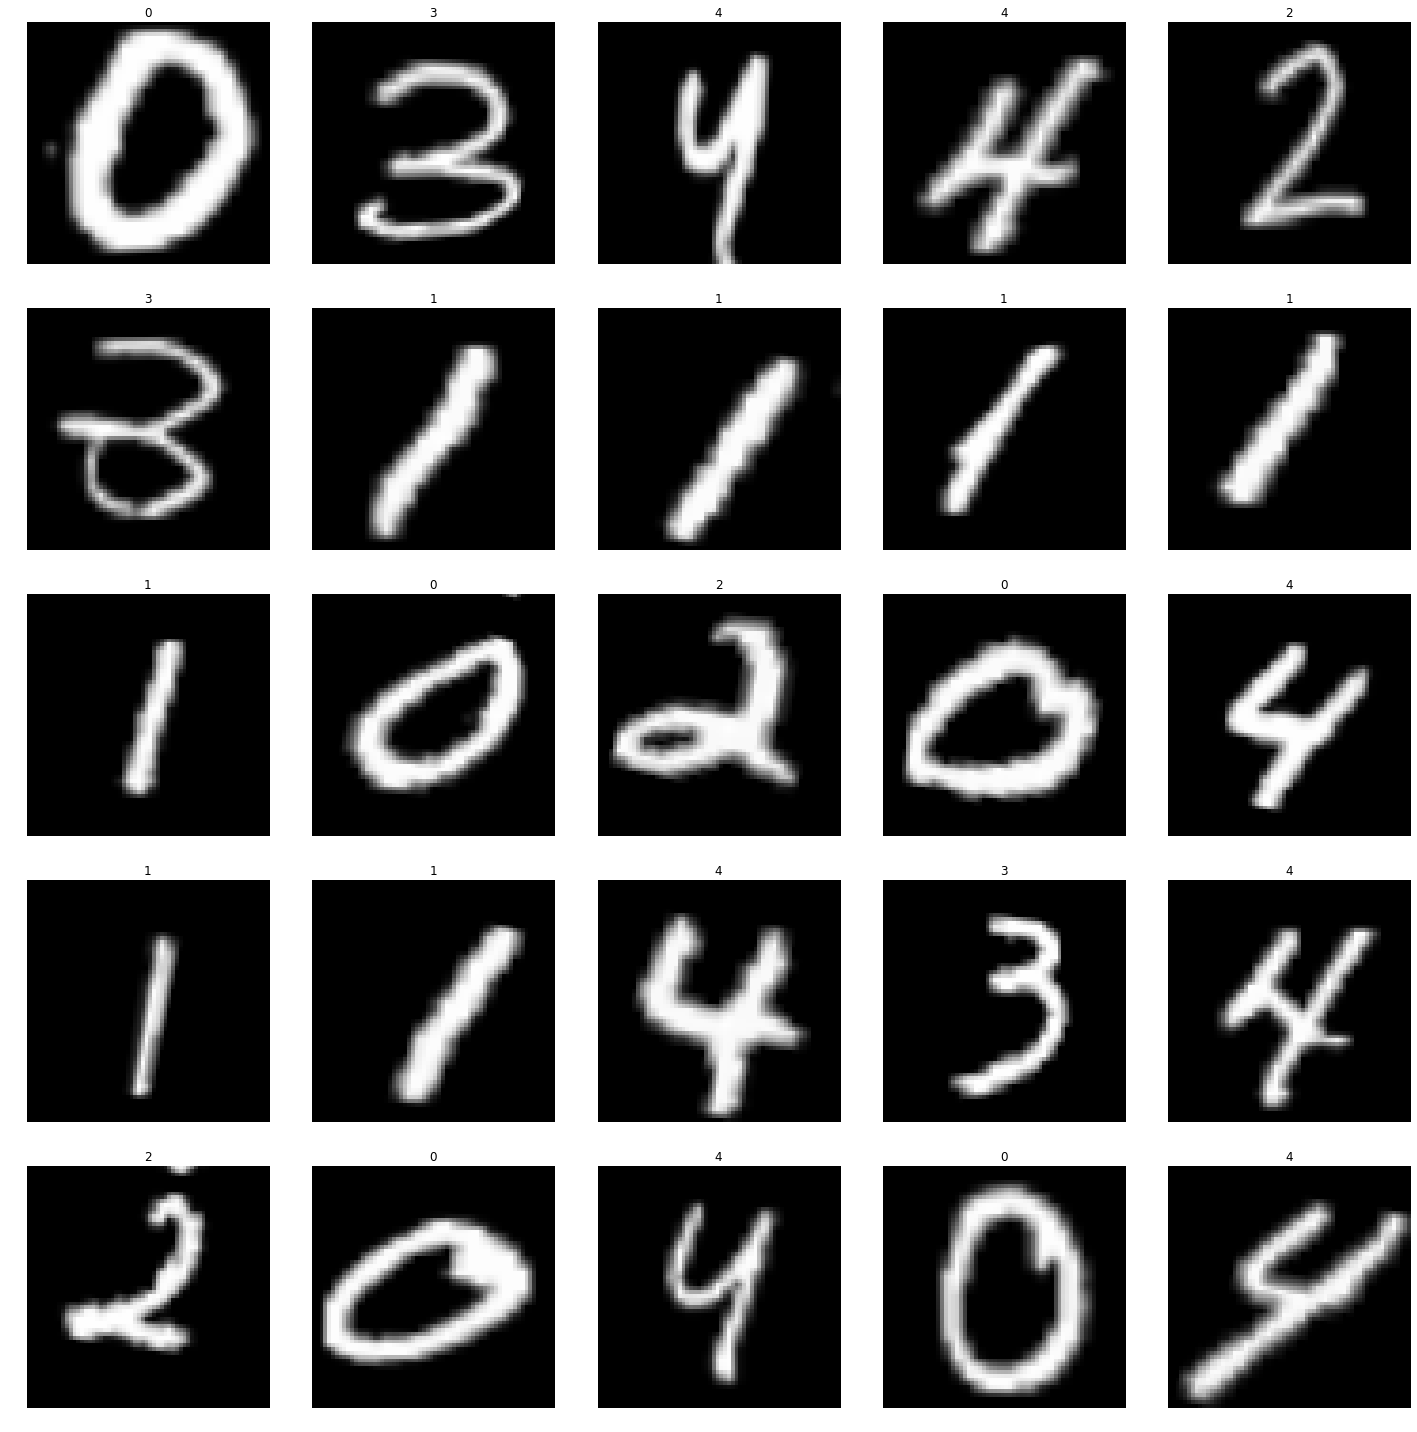

In [16]:
with IPyExperiments():
    xb, yb = data.one_batch()
    data.show_batch()

### ArcLoss Model

In [17]:
import pdb
from fastai.metrics import accuracy
from fastai.layers import *
from torch import nn
import torch.nn.functional as F
import torch
from fastai.callbacks import TerminateOnNaNCallback
from fastai.basic_data import DatasetType
from torch.nn.parameter import Parameter
from torch.nn import init

In [18]:
class ArcLoss(nn.Module):
    def __init__(self, margin=0.5, scale=64):
        super().__init__()
        self.margin = margin
        self.scale = scale
        
    def forward(self, logits, target): 
        """
        - Normalize W and xi by l1 norm
        - Find original logit
        - Find theta for original target logit
        - Calculate marginal target logit
        - Calculate diff in marginal and original logit
        - Add it to original 
        - Scale logits
        - Calc cross entropy
        """
#         pdb.set_trace()        
        one_hot_gt = torch.eye(data.c)[target].byte().cuda()
        original_target_logits = logits.masked_select(one_hot_gt)
#         print(original_target_logits) 
        # -1 + eps to 1-eps with eps = 1e-7.
        # lifesaver: https://github.com/pytorch/pytorch/issues/8069
        thetas = torch.acos(original_target_logits.clamp_(-1+1e-7, 1-1e-7))
#         print(thetas)
        marginal_target_logits = torch.cos(thetas + self.margin)
        
        margin_target_diffs = marginal_target_logits - original_target_logits
        logits = logits + (one_hot_gt.float() * margin_target_diffs[:,None])
        logits = logits * self.scale
        probas = F.softmax(logits, dim=1)
#         print(probas)
        return F.cross_entropy(probas, target)
    
    def __repr__(self):
        return f"{self._get_name()} Margin : {self.margin}, Scale : {self.scale}"
    def __str__(self):
        return f"{self._get_name()} Margin : {self.margin}, Scale : {self.scale}"

In [84]:
class FaceLoss(nn.Module):
    def __init__(self, m1=1, m2=0, m3=0, scale=64):
        super().__init__()
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.scale = scale
        
    def forward(self, logits, target): 
        """
        - Normalize W and xi by l1 norm
        - Find original logit
        - Find theta for original target logit
        - Calculate marginal target logit
        - Calculate diff in marginal and original logit
        - Add it to original 
        - Scale logits
        - Calc cross entropy
        """
#         pdb.set_trace()        
#         print(logits[:2])
        one_hot_gt = torch.eye(data.c)[target].byte().cuda()
        original_target_logits = logits.masked_select(one_hot_gt)
#         print(original_target_logits) 
        # -1 + eps to 1-eps with eps = 1e-7.
        # lifesaver: https://github.com/pytorch/pytorch/issues/8069
        thetas = torch.acos(original_target_logits.clamp_(-1+1e-7, 1-1e-7))
#         print(thetas)
        marginal_target_logits = torch.cos(self.m1*thetas + self.m2) - self.m3
        
#         margin_target_diffs = marginal_target_logits - original_target_logits
        logits = self.scale * ((one_hot_gt.float()) * marginal_target_logits[:,None] + ((1 - one_hot_gt.float())) * logits)
#         print(logits[:2])
        probas = F.softmax(logits, dim=1)
#         print(probas)
        return F.cross_entropy(probas, target)
    
    def __repr__(self):
        return f"{self._get_name()} Margins : {(self.m1, self.m2, self.m3)}, Scale : {self.scale}"
    def __str__(self):
        return f"{self._get_name()} Margins : {(self.m1, self.m2, self.m3)}, Scale : {self.scale}"

In [85]:
class ArcHead(nn.Module):
    def __init__(self, n_features=512, p=0.5):
        super().__init__()
        self.layers = nn.Sequential(*(
                        [AdaptiveConcatPool2d(), Flatten()]+\
                        bn_drop_lin(1024, 128, p=p, actn=nn.ReLU())+\
                        bn_drop_lin(128, n_features, p=p, actn=None)+\
                        [nn.BatchNorm1d(n_features),
                         nn.Linear(n_features, data.c, bias=False)]))
        
    def forward(self, x):    
        """bs x n_features"""
        # embedding feature
        x = self.layers[:-1](x); x = F.normalize(x)
        # class center weight 
        self.layers[-1].weight.data.div_(self.layers[-1].weight.norm(dim=0))
        logits = self.layers[-1](x)
#         print(logits)
        return logits

In [86]:
custom_head = ArcHead(n_features=2)
learner = create_cnn(data, models.resnet18, custom_head=custom_head, metrics=[accuracy],
                     callbacks=[TerminateOnNaNCallback()], model_dir="../models/")
loss = FaceLoss(1, 0.25, 0,scale=12); print(loss) 
learner.loss_func = loss

FaceLoss Margins : (1, 0.25, 0), Scale : 12


In [87]:
learner.model[1]

ArcHead(
  (layers): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Lambda()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1024, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=128, out_features=2, bias=True)
    (9): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=2, out_features=5, bias=False)
  )
)

In [48]:
# with IPyExperiments():
#     xb,yb = data.one_batch(ds_type=DatasetType.Train)
#     print(xb.shape, yb.shape)
#     out = learner.model(xb.cuda())
#     print(out.shape)
#     loss_ = loss(out, yb.cuda())
#     print(loss_)
#     acc = learner.metrics[0](out, yb.cuda())
#     print(acc)

In [88]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


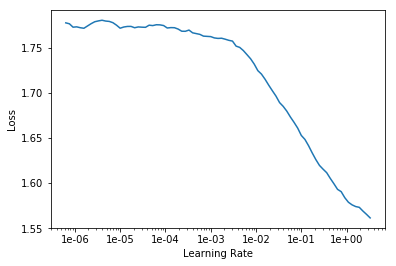

In [89]:
learner.recorder.plot()

In [90]:
# arcloss
learner.fit_one_cycle(20, max_lr=1e-1, wd=1e-4)

epoch,train_loss,valid_loss,accuracy
1,1.127429,1.124045,0.786135
2,1.134092,1.120878,0.788751
3,1.137339,1.129406,0.780249
4,1.128638,1.147951,0.769130
5,1.125840,1.121066,0.788751
6,1.117211,1.121988,0.788097
7,1.118409,1.120181,0.788751
8,1.117939,1.117774,0.790713
9,1.121705,1.118428,0.789405
10,1.116327,1.117065,0.791367


KeyboardInterrupt: 

In [31]:
# softmax
learner.fit_one_cycle(5, max_lr=1e-1, wd=1e-4)

epoch,train_loss,valid_loss,accuracy
1,1.016585,1.086805,0.827992
2,0.974421,0.949547,0.970569
3,0.960110,0.938622,0.975147
4,0.944357,0.926891,0.986266
5,0.935205,0.922379,0.991498


### Add hook to get features during inference

In [91]:
from fastai.callbacks import hook_outputs
from fastai.basic_data import DatasetType
from fastai.torch_core import *

In [92]:
[children(children(learner.model[1])[0])[-2]]

[BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

In [93]:
# register a hook to grab features
hook = hook_outputs([children(children(learner.model[1])[0])[-2]])

In [94]:
xb, yb = data.one_batch(ds_type=DatasetType.Valid)

In [95]:
model = learner.model.eval()
outb = model(xb.cuda())

In [96]:
outb.shape

torch.Size([64, 5])

In [97]:
# normalize features to have norm ||x|| = 1
out_features = F.normalize(hook.stored[0])
out_features[0].norm().data.item()

1.0

In [98]:
out_features = to_np(out_features.data)

In [99]:
out_features.shape

(64, 2)

In [100]:
(out_features[0]**2).sum()

1.0

### Visualize Validation Data

In [101]:
import seaborn as sns

In [102]:
centers = F.normalize(children(children(learner.model[1])[0])[-1].weight.data)
centers = to_np(centers)

In [103]:
colors = dict(zip(range(data.c),sns.color_palette()))
colors = {k:np.array(colors[k])[None] for k in colors}
colors

{0: array([[0.121569, 0.466667, 0.705882]]),
 1: array([[1.      , 0.498039, 0.054902]]),
 2: array([[0.172549, 0.627451, 0.172549]]),
 3: array([[0.839216, 0.152941, 0.156863]]),
 4: array([[0.580392, 0.403922, 0.741176]])}

#### ArcLoss

*** Loading backend: pytorch

*** Starting experiment...

*** Current state:
Gen RAM Free 54.6 GB | Proc size 3.2 GB
GPU RAM Free  6.1 GB | Used 10.9 GB | Util 178.7% | Total 16.9 GB



*** Finishing experiment...

*** Deleting the following local variables:
['ax', 'fig', 'i', 'label', 'x', 'y']

*** Potential memory leaks during the experiment:
cleared 115 objects

*** RAM consumed during the experiment:
Gen: 12.3 KB
GPU: 0 B

*** RAM reclaimed at the end of the experiment:
Gen: 0 B (0.00%)
GPU: 0 B (100.00%)

*** Elapsed wallclock time:
00:00:05

*** Current state:
Gen RAM Free 54.6 GB | Proc size 3.2 GB
GPU RAM Free  6.1 GB | Used 10.9 GB | Util 178.7% | Total 16.9 GB




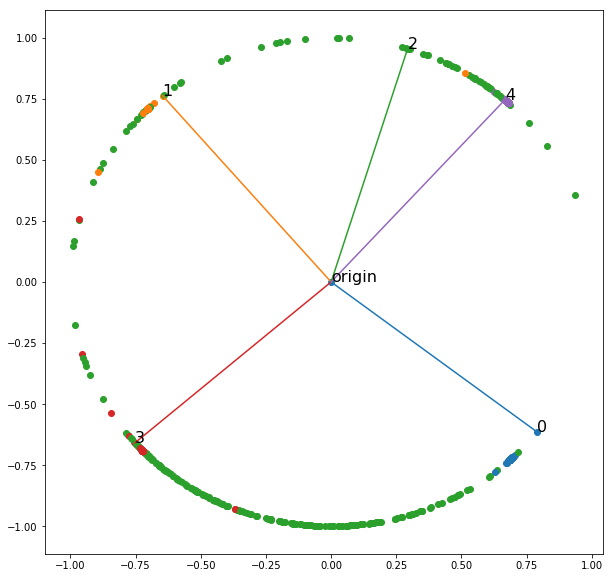

In [104]:
# ARCLOSS
with IPyExperiments():
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    for i, (x,y) in enumerate(zip(centers[:,0], centers[:,1])):
        ax.scatter(x,y, c=colors[i])
        ax.plot((0,x), (0,y))
        ax.text(x,y,i,size=16)
    ax.scatter(0,0)
    ax.text(0,0,'origin',size=16)

    # add validation data
    for xb, yb in learner.data.valid_dl:
        outb = model(xb.cuda())
        out_features = F.normalize(hook.stored[0])
        for label, (x,y) in zip(to_np(yb), out_features):
            ax.scatter(x,y,c=colors[label])

In [76]:
F.normalize(children(learner.model[1])[0][-1].weight)**2

tensor([[0.0079, 0.9921],
        [0.0388, 0.9612],
        [0.0078, 0.9922],
        [0.9575, 0.0425],
        [0.0080, 0.9920]], device='cuda:0', grad_fn=<PowBackward0>)

#### Softmax 

*** Loading backend: pytorch

*** Starting experiment...

*** Current state:
Gen RAM Free 54.8 GB | Proc size 3.2 GB
GPU RAM Free  6.2 GB | Used 10.7 GB | Util 172.2% | Total 16.9 GB



*** Finishing experiment...

*** Deleting the following local variables:
['ax', 'fig', 'i', 'label', 'x', 'y']

*** Potential memory leaks during the experiment:
cleared 120 objects

*** RAM consumed during the experiment:
Gen: 9.8 MB
GPU: 155.2 MB

*** RAM reclaimed at the end of the experiment:
Gen: 0 B (0.00%)
GPU: 107.0 MB (68.92%)

*** Elapsed wallclock time:
00:00:05

*** Current state:
Gen RAM Free 54.8 GB | Proc size 3.2 GB
GPU RAM Free  6.2 GB | Used 10.8 GB | Util 174.4% | Total 16.9 GB




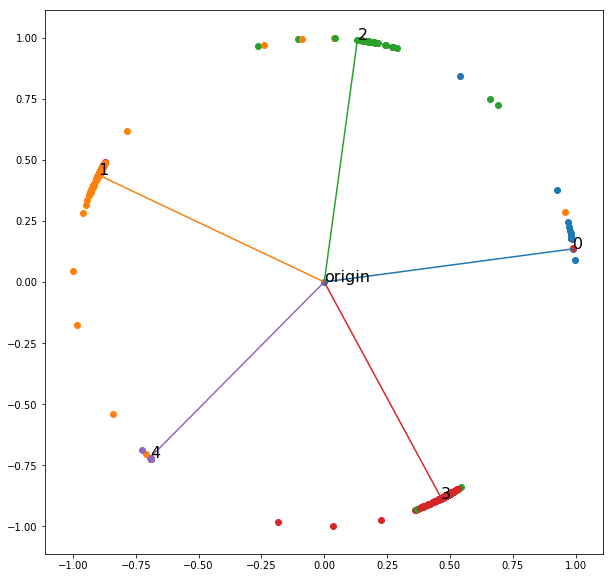

In [45]:
# SOFTMAX
with IPyExperiments():
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    for i, (x,y) in enumerate(zip(centers[:,0], centers[:,1])):
        ax.scatter(x,y, c=colors[i])
        ax.plot((0,x), (0,y))
        ax.text(x,y,i,size=16)
    ax.scatter(0,0)
    ax.text(0,0,'origin',size=16)

    # add validation data
    for xb, yb in learner.data.valid_dl:
        outb = model(xb.cuda())
        out_features = F.normalize(hook.stored[0])
        for label, (x,y) in zip(to_np(yb), out_features):
            ax.scatter(x,y,c=colors[label])

In [46]:
len(data.valid_ds)

1529